In [1]:
# 1. Установка библиотек
!pip install timm lightning pytorch-lightning pytorch-metric-learning faiss-cpu opencv-python-headless grad-cam tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 146.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 50.2 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=1aeb295204192b8e301b6e880efdc6373efd36c954ea2770e0da04382febfcf9
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [2]:
# 2. Импорт модулей
import torch
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd
import os, cv2, random, tqdm
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [3]:
# 3. Гиперпараметры и device
BATCH_SIZE = 64
EMB_SIZE = 512
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
AUG_SIZE = 224


In [4]:
# Скачиваем meta
!gdown 1PD-lbbcKSelDeAYKafe3boc5mqqEe7X7 -O cars196_meta.zip
# Скачиваем data
!gdown 1l9EnYMC-xGX706SY1kN8RceMmFViASfx -O cars196_data.zip

# Распаковываем meta
!unzip cars196_meta.zip -d devkit
# Распаковываем data
!unzip cars196_data.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: cars_train/cars_train/03145.jpg  
  inflating: cars_train/cars_train/03146.jpg  
  inflating: cars_train/cars_train/03147.jpg  
  inflating: cars_train/cars_train/03148.jpg  
  inflating: cars_train/cars_train/03149.jpg  
  inflating: cars_train/cars_train/03150.jpg  
  inflating: cars_train/cars_train/03151.jpg  
  inflating: cars_train/cars_train/03152.jpg  
  inflating: cars_train/cars_train/03153.jpg  
  inflating: cars_train/cars_train/03154.jpg  
  inflating: cars_train/cars_train/03155.jpg  
  inflating: cars_train/cars_train/03156.jpg  
  inflating: cars_train/cars_train/03157.jpg  
  inflating: cars_train/cars_train/03158.jpg  
  inflating: cars_train/cars_train/03159.jpg  
  inflating: cars_train/cars_train/03160.jpg  
  inflating: cars_train/cars_train/03161.jpg  
  inflating: cars_train/cars_train/03162.jpg  
  inflating: cars_train/cars_train/03163.jpg  
  inflating: cars_train/cars_train/0316

In [5]:
# 4. Загрузка данных и метаданных
import scipy.io

mat = scipy.io.loadmat('/content/devkit/devkit/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']],
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('/content/devkit/devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}
ADD_PATH = './cars_train'  # путь к папке с картинками

In [6]:
# 5. Аугментации
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomResizedCrop(AUG_SIZE),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(0.2,0.2,0.2,0.1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.225])
])
val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((AUG_SIZE, AUG_SIZE)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.225])
])

In [7]:
# 6. Датасет
class CropClassifDataset(Dataset):
    def __init__(self, cars_items, transforms):
        self.cars = cars_items
        self.transforms = transforms

    def __len__(self):
        return len(self.cars)

    def __getitem__(self, idx):
        filename, cl_id = self.cars[idx]
        image = cv2.imread(os.path.join(ADD_PATH, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            image = self.transforms(image)
        return {'image': image, 'label': cl_id}

In [8]:
# 7. Train/Val split
items = list(fname_to_class.items())
random.shuffle(items)
train_items = items[:int(0.8*len(items))]
val_items = items[int(0.8*len(items)):]

train_dataset = CropClassifDataset(train_items, train_transforms)
val_dataset = CropClassifDataset(val_items, val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
valid_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [9]:
# 8. Модель с выбором miner и scheduler

import timm
import lightning.pytorch as pl
from pytorch_metric_learning.losses import TripletMarginLoss
from pytorch_metric_learning.miners import TripletMarginMiner

class CarEmbedder(pl.LightningModule):
    def __init__(self, num_classes, emb_size, lr=3e-4, miner_type='semihard'):
        super().__init__()
        self.save_hyperparameters()
        self.model = timm.create_model('efficientnet_b0', pretrained=True)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, emb_size)
        self.miner = TripletMarginMiner(margin=0.2, type_of_triplets=miner_type)
        self.loss_func = TripletMarginLoss(margin=0.2)
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['label']
        embeds = self(images)
        mining_indices = self.miner(embeds, labels)
        loss = self.loss_func(embeds, labels, mining_indices)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['label']
        embeds = self(images)
        mining_indices = self.miner(embeds, labels)
        loss = self.loss_func(embeds, labels, mining_indices)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
                'interval': 'epoch',
                'frequency': 1
            }
        }

In [10]:
# 9. Тренировка с miner и scheduler

from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor

ADD_PATH = '/content/cars_train/cars_train'

pl_model = CarEmbedder(num_classes=len(id_to_car), emb_size=EMB_SIZE, lr=3e-4, miner_type='hard')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=2)
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=4)
lr_monitor = LearningRateMonitor(logging_interval='step')

trainer = pl.Trainer(
    max_epochs=20,
    accelerator=DEVICE,
    devices=1,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor],
    log_every_n_steps=20
)
trainer.fit(pl_model, train_loader, valid_loader)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | EfficientNet       | 4.7 M  | train
1 | miner     | TripletMarginMiner | 0      | train
2 | loss_func | TripletMarginLoss  | 0      | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.654    Total estimated model params size (MB)
342       Modules in train mo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [11]:
# 10. Получение эмбеддингов с отображением loss

def get_embeds(model, loader):
    model.eval()
    model.to(DEVICE)
    embeddings = []
    labels = []
    losses = []
    with torch.no_grad():
        for batch in tqdm.tqdm(loader):
            imgs = batch['image'].to(DEVICE)
            lbls = batch['label']
            embs = model(imgs).cpu().numpy()
            embeddings.append(embs)
            labels.append(lbls.numpy())
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    return embeddings.astype(np.float32), labels

train_emb, train_labels = get_embeds(pl_model, train_loader)
val_emb, val_labels = get_embeds(pl_model, valid_loader)

100%|██████████| 26/26 [00:12<00:00,  2.05it/s]


In [18]:
# 11. Индексирование FAISS (с нормализацией для корректного поиска)
import faiss
import torch
import numpy as np

train_emb_norm = torch.nn.functional.normalize(torch.tensor(train_emb), p=2, dim=1).numpy()
val_emb_norm = torch.nn.functional.normalize(torch.tensor(val_emb), p=2, dim=1).numpy()

index = faiss.IndexFlatIP(EMB_SIZE)
index.add(train_emb_norm)

k = 4
D, I = index.search(val_emb_norm, k)
retrieved_labels = train_labels[I]

In [19]:
# 12. Метрики + логирование loss

def precision_at_k(query_labels, retrieved_labels, k):
    precisions = []
    for q_label, r_labels in zip(query_labels, retrieved_labels):
        precisions.append(np.sum(r_labels[:k]==q_label)/k)
    return np.mean(precisions)

def recall_at_k(query_labels, retrieved_labels, k):
    recalls = []
    for q_label, r_labels in zip(query_labels, retrieved_labels):
        total_relevant = np.sum(r_labels==q_label)
        retrieved_relevant = np.sum(r_labels[:k]==q_label)
        recalls.append(retrieved_relevant/(total_relevant if total_relevant>0 else 1))
    return np.mean(recalls)

def average_precision(query_label, retrieved_labels):
    hits, sum_precisions = 0, 0
    for i, lbl in enumerate(retrieved_labels, 1):
        if lbl == query_label:
            hits += 1
            sum_precisions += hits / i
    return sum_precisions / (hits if hits>0 else 1)

def mean_average_precision(query_labels, retrieved_labels):
    return np.mean([average_precision(q, r) for q, r in zip(query_labels, retrieved_labels)])

print(f'Precision@{k}: {precision_at_k(val_labels, retrieved_labels, k):.4f}')
print(f'Recall@{k}: {recall_at_k(val_labels, retrieved_labels, k):.4f}')
print(f'mAP: {mean_average_precision(val_labels, retrieved_labels):.4f}')

Precision@4: 0.2460
Recall@4: 0.5740
mAP: 0.4125


Найдено ошибок @1: 1093


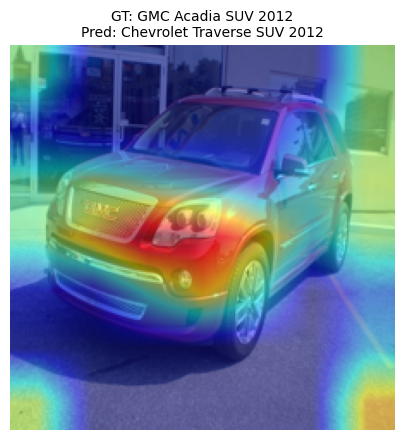

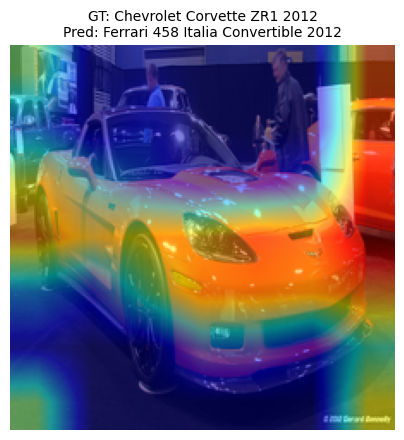

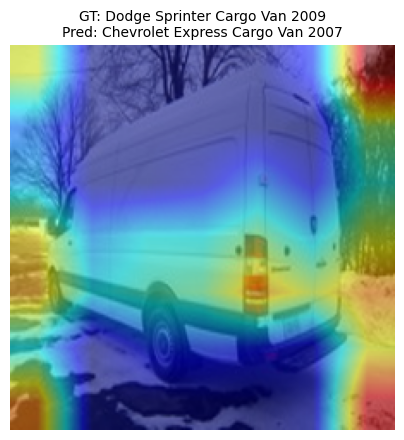

In [20]:
# 13. GradCAM для ошибок

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layers = [pl_model.model.blocks[-1]]

def show_grad_cam(model, image_path, target_layers, label_gt=None, label_pred=None):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Изображение не найдено: {image_path}")
        return
    rgb_np = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(rgb_np)
    pil_resized = pil_img.resize((AUG_SIZE, AUG_SIZE))
    tensor_img = torchvision.transforms.ToTensor()(pil_resized)
    normalized_tensor = torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )(tensor_img)
    input_tensor = normalized_tensor.unsqueeze(0).to(DEVICE)
    rgb_for_cam = np.array(pil_resized).astype(np.float32) / 255.0
    rgb_for_cam = np.clip(rgb_for_cam, 0.0, 1.0)
    cam = GradCAM(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor)[0, :]
    cam_img = show_cam_on_image(rgb_for_cam, grayscale_cam, use_rgb=True)
    plt.figure(figsize=(5, 5))
    plt.imshow(cam_img)
    if label_gt is not None:
        plt.title(f"GT: {label_gt}\nPred: {label_pred}", fontsize=10)
    plt.axis('off')
    plt.show()

wrong = np.where(val_labels != retrieved_labels[:, 0])[0]
print(f"Найдено ошибок @1: {len(wrong)}")

for i, idx in enumerate(wrong[:3]):
    filename, cl_id = val_dataset.cars[idx]
    image_path = os.path.join(ADD_PATH, filename)
    gt = id_to_car[cl_id]
    pred = id_to_car[retrieved_labels[idx, 0]]
    show_grad_cam(
        model=pl_model.model,
        image_path=image_path,
        target_layers=target_layers,
        label_gt=gt,
        label_pred=pred
    )

In [21]:
# 14. Вывод результатов
print(f"Total test: {len(val_labels)} | Ошибок: {len(wrong)} | Точность @1: {(len(val_labels)-len(wrong))/len(val_labels):.4f}")

Total test: 1629 | Ошибок: 1093 | Точность @1: 0.3290


In [22]:
# 15. (Опционально) Сохранить эмбеддинги/модель
np.save('train_emb.npy', train_emb)
np.save('train_labels.npy', train_labels)
np.save('val_emb.npy', val_emb)
np.save('val_labels.npy', val_labels)
torch.save(pl_model.state_dict(), 'car_metric_embedder_efficientnet.pth')